In [ ]:
# !pip install transformers
!pip install --no-cache-dir transformers sentencepiece
import json
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel, AutoModelForSeq2SeqLM
import torch
from collections import defaultdict
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
from matplotlib.pyplot import figure

import nltk
nltk.download('punkt')

     |████████████████████████████████| 4.0 MB 28.5 MB/s 
     |████████████████████████████████| 1.2 MB 66.2 MB/s 
     |████████████████████████████████| 895 kB 61.3 MB/s 
     |████████████████████████████████| 596 kB 8.9 MB/s 
     |████████████████████████████████| 6.6 MB 22.8 MB/s 
     |████████████████████████████████| 77 kB 13.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/tydiqa/data/tydiqa-goldp-v1.1-train.json") as f:
  train_data = json.load(f)
  print(train_data.keys())

dict_keys(['data', 'version'])


###Peek into data

In [ ]:
train_data['data'][:5]

[{'paragraphs': [{'context': 'Charles Hoy Fort (6. elokuuta (joidenkin lähteiden mukaan 9.) 1874 – 3. toukokuuta 1932) oli yhdysvaltalainen kirjailija ja paranormaalien ilmiöiden tutkija.',
    'qas': [{'answers': [{'answer_start': 18,
        'text': '6. elokuuta (joidenkin lähteiden mukaan 9.) 1874'}],
      'id': 'finnish--7633091408814529542-0',
      'question': 'Milloin Charles Fort syntyi?'}]}],
  'title': 'Charles Fort'},
 {'paragraphs': [{'context': '   Altruismi ([1],  ”toinen”[2]) tarkoittaa epäitsekästä ja pyyteetöntä[3] [4] toimintaa, jossa toisen hyvä asetetaan oman edun edelle.[5] Altruismin vastakohta on egoismi.[6] Termin esitti ranskalainen filosofi Auguste Comte vuonna 1851, jolloin hän määritteli altruismin uhrautumiseksi muiden eduksi.[1]',
    'qas': [{'answers': [{'answer_start': 44,
        'text': 'epäitsekästä ja pyyteetöntä[3] [4] toimintaa, jossa toisen hyvä asetetaan oman edun edelle'}],
      'id': 'finnish-8742325368463988542-0',
      'question': 'Mitä o

In [ ]:
train_data['data'][-5:]

[{'paragraphs': [{'context': 'মুহাম্মাদ মুরসি ইসা আল-আইয়াত (Egyptian Arabic: محمد مرسى عيسى العياط\u200e, IPA:[mæˈħammæd ˈmʊɾsi ˈʕiːsæ l.ʕɑjˈjɑːtˤ], জন্মঃ ২০ অগাস্ট, ১৯৫১) একজন মিশরীয় রাজনীতিবিদ, প্রকৌশলী এবং মিশরের বর্তমান ও পঞ্চম রাষ্ট্রপতি।।[1]',
    'qas': [{'answers': [{'answer_start': 121, 'text': '২০ অগাস্ট, ১৯৫১'}],
      'id': 'bengali--1108486140398659321-0',
      'question': 'মুহাম্মাদ মুরসি ইসা আল-আইয়াত কবে জন্মগ্রহণ করেন ?'}]}],
  'title': 'মুহাম্মাদ মুরসি'},
 {'paragraphs': [{'context': 'আনুমানিক ৫৭০ খ্রিস্টাব্দে (হস্তিবর্ষ) মক্কা নগরীতে জন্ম নেওয়া মুহাম্মাদ মাতৃগর্বে থাকাকালীন পিতা হারা হন শিশু বয়সে মাতাকে হারিয়ে এতিম হন এবং প্রথমে তাঁর পিতামহ আবদুল মোত্তালিব ও পরে পিতৃব্য আবু তালিবের নিকট লালিত পালিত হন। হেরা পর্বতের গুহায় ধ্যানমগ্ন থাকার পর ৪০ বছর বয়সে তিনি নবুওয়াত লাভ করেন। জিবরাইল এই পর্বতের গুহায় আল্লাহর তরফ থেকে তাঁর নিকট ওহী নিয়ে আসেন।[16] তিন বছর পর ৬১০ খ্রিস্টাব্দে[17] মুহাম্মাদ প্রকাশ্যে ওহী প্রচার করেন,[18] এবং ঘোষণা দেন "আল্লাহ এক" ও তাঁর নিকট নিজ

In [ ]:
len(train_data['data'])

49881

###XLM Roberta Embeddings

In [ ]:
from collections import defaultdict

lang_to_count = defaultdict(int)
for datum in train_data['data']:
  for para in datum['paragraphs']:
    for qa in para['qas']:
      lang = qa['id'].split("-")[0]
      lang_to_count[lang] += 1
print(lang_to_count)

defaultdict(<class 'int'>, {'finnish': 6855, 'telugu': 5563, 'russian': 6490, 'arabic': 14805, 'indonesian': 5702, 'english': 3696, 'swahili': 2755, 'korean': 1625, 'bengali': 2390})


In [ ]:
train_data['data'][0]['paragraphs'][0]['qas'][0]['id']

'finnish--7633091408814529542-0'

In [ ]:
print(lang_to_count.sort)

AttributeError: ignored

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

In [ ]:
for idx, datum in enumerate(train_data['data']):
  for para in datum['paragraphs']:
    for qa in para['qas']:
      question = qa['question']
      encoded_input = tokenizer(question, return_tensors='pt')
      output = model(**encoded_input)

  if idx == 2:
    break

In [ ]:
output.logits.shape

torch.Size([1, 11, 250002])

In [ ]:
encoded_input

{'input_ids': tensor([[     0,  83113,   1194,  96513, 142092, 203217,  24943,   2601,  14907,
             32,      2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

###Sentence Embeddings

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [ ]:
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
# tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
# model = AutoModel.from_pretrained('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/distiluse-base-multilingual-cased-v2')
model = AutoModel.from_pretrained('sentence-transformers/distiluse-base-multilingual-cased-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, max pooling.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

print("Sentence embeddings:")
print(sentence_embeddings)


Downloading:   0%|          | 0.00/531 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/610 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/514M [00:00<?, ?B/s]

Sentence embeddings:
tensor([[ 0.0789,  0.0301, -0.1049,  ...,  0.0582,  0.0896, -0.0407],
        [ 0.0042,  0.0390, -0.0065,  ...,  0.0326, -0.0006, -0.0060]])


In [ ]:
sentence_embeddings.shape

torch.Size([2, 768])

In [ ]:
questions = defaultdict(list)
for datum in train_data['data']:
  for para in datum['paragraphs']:
    for qa in para['qas']:
      lang = qa['id'].split("-")[0]
      if lang == "english":
        questions["en"].append(qa['question'])
      elif lang == "finnish":
        questions["fi"].append(qa['question'])

In [ ]:
for q in questions:
  print(q, len(questions[q]))

fi 6855
en 3696


In [ ]:
sent_embed = defaultdict(list)
for lang, sentences in questions.items():
  sentences = sentences[:500]
  encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

  # Compute token embeddings
  with torch.no_grad():
      model_output = model(**encoded_input)

  # Perform pooling. In this case, max pooling.
  sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
  sent_embed[lang] = sentence_embeddings

In [ ]:
X = np.array([emb.tolist() for emb in sent_embed['en']] + [emb.tolist() for emb in sent_embed['fi']] )
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
y = np.array([0 for i in range(len(sent_embed['en']))] + [1 for i in range(len(sent_embed['en']))])

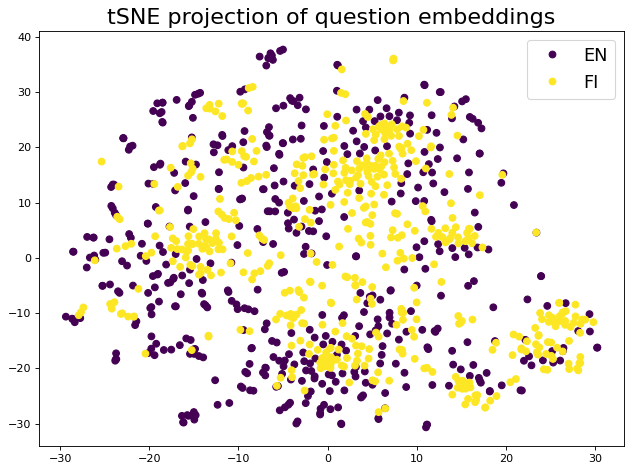

In [ ]:
figure(figsize=(8, 6), dpi=80)
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y)
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, ["EN", "FI"], fontsize=16)
plt.title("tSNE projection of question embeddings", fontsize=20)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/tydiqa/fig/en_fi_tsne_distiluse.pdf')

In [ ]:
candidate_pairs = []
cos_result = np.zeros((len(sent_embed['en']), len(sent_embed['fi'])))
for en_idx, en_emb in enumerate(sent_embed['en']):
  for fi_idx, fi_emb in enumerate(sent_embed['fi']):
    cos_sim = 1 - spatial.distance.cosine(en_emb, fi_emb)
    cos_result[en_idx, fi_idx] = cos_sim
    candidate_pairs.append((en_idx, fi_idx, cos_sim))

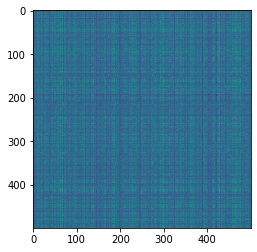

In [ ]:
plt.imshow(cos_result)

In [ ]:
len(candidate_pairs), np.mean(np.abs(cos_result))

(250000, 0.2560932323182553)

In [ ]:
for en_idx, fi_idx, cos_sim in candidate_pairs:
  print(questions['en'][en_idx], questions['fi'][fi_idx], cos_sim)
  break

When was quantum field theory developed? Milloin Charles Fort syntyi? 0.40966352820396423


In [ ]:
import csv  

header = ['en_question', 'fi_question', 'cos_sim']
data = [[questions['en'][e], questions['fi'][f],c] for e, f, c in candidate_pairs]

with open('/content/drive/MyDrive/tydiqa/en_fi_sim_pairs_distiluse_0419.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerows(data)


In [ ]:
data[0]

['When was quantum field theory developed?',
 'Milloin Charles Fort syntyi?',
 0.40966352820396423]

In [ ]:
count = 0
for e, f, c in candidate_pairs:
  if c > 0.5:
    count += 1

count

4899

###Translation

In [ ]:
fi2en_tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-fi-en")
fi2en_model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-fi-en")
# fi2en_model = fi2en_model.to('cuda')

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/812k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/771k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/287M [00:00<?, ?B/s]

In [ ]:
print(fi2en_tokenizer)

PreTrainedTokenizer(name_or_path='Helsinki-NLP/opus-mt-fi-en', vocab_size=59659, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})


In [ ]:
all_src_text = questions['fi'][:500]
translated = []
i = 0
while i <= 450:
  src_text = all_src_text[i:i+50]
  encoded_input = fi2en_tokenizer(src_text, padding=True, truncation=True, return_tensors='pt') #.to('cuda')
  print(encoded_input)
  # with fi2en_tokenizer.as_target_tokenizer():
  #   labels = fi2en_tokenizer(tgt_texts, ...)
  with torch.no_grad():
      model_output = fi2en_model.generate(**encoded_input)
  # translated = [tokenizer.decode(t, skip_special_tokens=True) for t in model_output]
  out = fi2en_tokenizer.batch_decode(model_output, skip_special_tokens=True)
  translated.extend(out)
  i += 50

# model_inputs = tokenizer(src_texts, ...)
# with tokenizer.as_target_tokenizer():
#     labels = tokenizer(tgt_texts, ...)
# model_inputs["labels"] = labels["input_ids"]

{'input_ids': tensor([[ 5116,  6841,   321,  ..., 59658, 59658, 59658],
        [  159,     7,  2340,  ..., 59658, 59658, 59658],
        [  576,    80, 12485,  ..., 59658, 59658, 59658],
        ...,
        [  576,     7, 16757,  ..., 59658, 59658, 59658],
        [ 1073,     7, 31370,  ..., 59658, 59658, 59658],
        [ 5116,  1805,   443,  ..., 59658, 59658, 59658]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
{'input_ids': tensor([[  576,    80,  3663,   371,    44,    13, 17006,    44,  8962, 12993,
          1405,    18,    19, 20975,   457, 17902,  4516,    12,     0],
        [ 5116,  7647,  4723, 11586,    10,    80,  9964,    12,     0, 59658,
         59658, 59658, 59658, 59658, 59658, 59658, 59658, 59658, 59658],
        [ 1042,  2073,  2453, 16081,   371, 10372,    12,     0, 596

In [ ]:
len(src_text), len(translated)

(50, 500)

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)

1.0


In [ ]:
import csv
from nltk.translate.bleu_score import SmoothingFunction  

header = ['en_question', 'fi_question', 'fi_to_en', 'cos_sim', 'bleu']
# data = [[questions['en'][e], questions['fi'][r],c] for e, r, c in candidate_pairs]
data = []
for e, f, cos_sim in candidate_pairs:
  en_question = questions['en'][e]
  fi_question = questions['fi'][f]

  ref = word_tokenize(en_question)
  tra = word_tokenize(translated[f])
  bleu = sentence_bleu(ref, tra, smoothing_function=SmoothingFunction().method1)
  data.append([en_question, fi_question, translated[f], cos_sim, bleu])
  

with open('/content/drive/MyDrive/tydiqa/en_fi_sim_pairs_distiluse_0419.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerows(data)


In [ ]:
cos_sim_arr = []
bleu_arr = []
for datum in data:
  cos_sim_arr.append(datum[3])
  bleu_arr.append(datum[4])

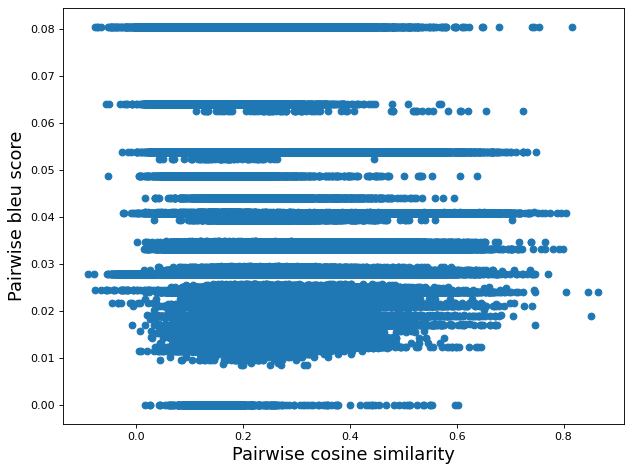

In [ ]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(cos_sim_arr, bleu_arr)
plt.xlabel("Pairwise cosine similarity", fontsize=16)
plt.ylabel("Pairwise bleu score", fontsize=16)
# plt.title("tSNE projection of question embeddings", fontsize=20)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/tydiqa/fig/fi_en_scatter_cos_vs_bleu_distiluse.pdf')

In [ ]:
for datum in data:
  if datum[3] > 0.7:
    print("{}\t{}\t{}".format(datum[0], datum[2], datum[1]))

What was the first film directed by Andrei Tarkovsky?	What was Alfred Hitchcock's first film?	Mikä oli Alfred Hitchcockin ensimmäinen elokuva?
Who was the last Han Dynasty Emperor?	Who was the last ruler of East Rome?	Kuka oli Itä-Rooman viimeinen hallitsija?
When was the first Spanish Grand Prix?	When was the Brazilian GP added to the F1 competitions?	Milloin Brasilian GP lisättiin F1 kilpailuihin?
When did Alfred die?	When did Aarne Slavetsalo die?	Milloin Aarne Orjatsalo kuoli?
How long is a general apprenticeship in terms of years?	How long is the guard's training?	Kuinka pitkä vartijan koulutus on?
What is an organophosphate?	What's phosphorence?	Mikä fosforesenssi on?
When was the Discovery Channel introduced?	When did YLE start broadcasting text TV?	Milloin Yleisradio aloitti teksti-TV-lähetykset?
When was the Royal Observer Corps established?	When was the Satakunta group founded?	Milloin Satakunnan ryhmä perustettiin?
Who is the WWE Champion?	What is SmackDown?	Mikä SmackDown! 